# Rayleigh drag
Display closeup of Rayleigh drag (if any).

Based on `/home/156/aek156/notebooks/github/aekiss/notebooks/bathymetry-closeup-KaraStr-Rayleighdamping.ipynb` https://github.com/aekiss/notebooks/blob/master/bathymetry-closeup-KaraStr-Rayleighdamping.ipynb

In [1]:
# Eliminate margins
# from https://stackoverflow.com/questions/44298864/how-can-i-eliminate-the-gray-border-around-jupyter-ipython-notebooks-in-my-brows
from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:97% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

In [2]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import numpy as np
import xarray as xr
from matplotlib import cm
import netCDF4 as nc
import IPython.display
import regex as re
import glob
import copy
import re

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [3]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=200, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=200, bbox_inches="tight")  # comment out to disable saving
    return

In [11]:
# load Rayleigh drag data from final field_table of each run
ft_data = copy.deepcopy(exptdata.exptdict)  # to store fields under the same keys as exptdata.exptdict
ft_data['1deg']['exptdir'] = '/g/data/e14/rmh561/access-om2/archive/1deg_jra55_ryf_kds50'
ft_data['025deg']['exptdir'] = '/g/data/e14/rmh561/access-om2/archive/025deg_jra55_ryf_norediGM'
ft_data['01deg']['exptdir'] = '/scratch/e14/rmh561/access-om2/archive/01deg_jra55_ryf_k_smag_iso7p9'
new_field_table01 = '/home/561/rmh561/access-om2/01deg_jra55_ryf_k_smag_iso7p9/ocean/field_table'

for ekey in ft_data.keys():
    ftde = ft_data[ekey]
    ftfiles = glob.glob(os.path.join(ftde['exptdir'], 'output*/ocean/field_table'))
    ftfiles.sort()
    ftfile = ftfiles[-1]
    print(ftfile)
    gridfile = xr.open_dataset(os.path.join(os.path.dirname(ftfile),'ocean_grid.nc'))
    ftde['geolon_c'] = gridfile.geolon_c
    ftde['geolat_c'] = gridfile.geolat_c
    ftde['kmu'] = gridfile.kmu
    ftde['hu'] = gridfile.hu  # hu has correct u-cell mask (kmu uses t-cell mask)

    if ekey=='01deg':
        ftfile = new_field_table01
    ftde['field_table'] = ftfile
        
    damp_table = ''
    with open(ftfile,"r") as f:
        for line in f:
            if line.startswith('"rayleigh_damp_table"'):
                break
        for line in f:
            if line.startswith('"rayleigh"'):
                damp_table += line
            else:
                pass

    ftde['damp_table_ii'] = [ int(i)-1 for i in re.findall('itable=(\d+)', damp_table) ]  # subtract 1 to index from 0
    ftde['damp_table_jj'] = [ int(j)-1 for j in re.findall('jtable=(\d+)', damp_table) ]  # subtract 1 to index from 0
    ftde['damp_time'] = [ int(j) for j in re.findall('rayleigh_damp_table=(\d+)', damp_table) ]
    ftde['ktable_1'] = [ int(j) for j in re.findall('ktable_1=(\d+)', damp_table) ]
    ftde['ktable_2'] = [ int(j) for j in re.findall('ktable_2=(\d+)', damp_table) ]

    # make damp time map; use kmu to get land mask
    dtm = ftde['hu'].where(np.isnan(ftde['hu']), 0)  # zero out ocean points
    for i, j, dt in zip(ftde['damp_table_ii'], ftde['damp_table_jj'], ftde['damp_time']):
        if not np.isnan(dtm[j][i]):
            dtm[j][i] = dt  # put damp_time value in at every ocean point that has damping
    ftde['damp_time_map'] = dtm

    # make map of number of non-damped cells in each damped column
    undamped = ftde['hu'].where(np.isnan(ftde['hu']), 0)  # zero out ocean points
    for i, j, kt1, kt2 in zip(ftde['damp_table_ii'], ftde['damp_table_jj'], ftde['ktable_1'], ftde['ktable_2']):
        if not np.isnan(undamped[j][i]):
            undamped[j][i] = max(0, ftde['kmu'][j][i] - kt2) + kt1 - 1
    ftde['undamped'] = undamped

/g/data/e14/rmh561/access-om2/archive/1deg_jra55_ryf_kds50/output032/ocean/field_table
/g/data/e14/rmh561/access-om2/archive/025deg_jra55_ryf_norediGM/output081/ocean/field_table
/scratch/e14/rmh561/access-om2/archive/01deg_jra55_ryf_k_smag_iso7p9/output642/ocean/field_table


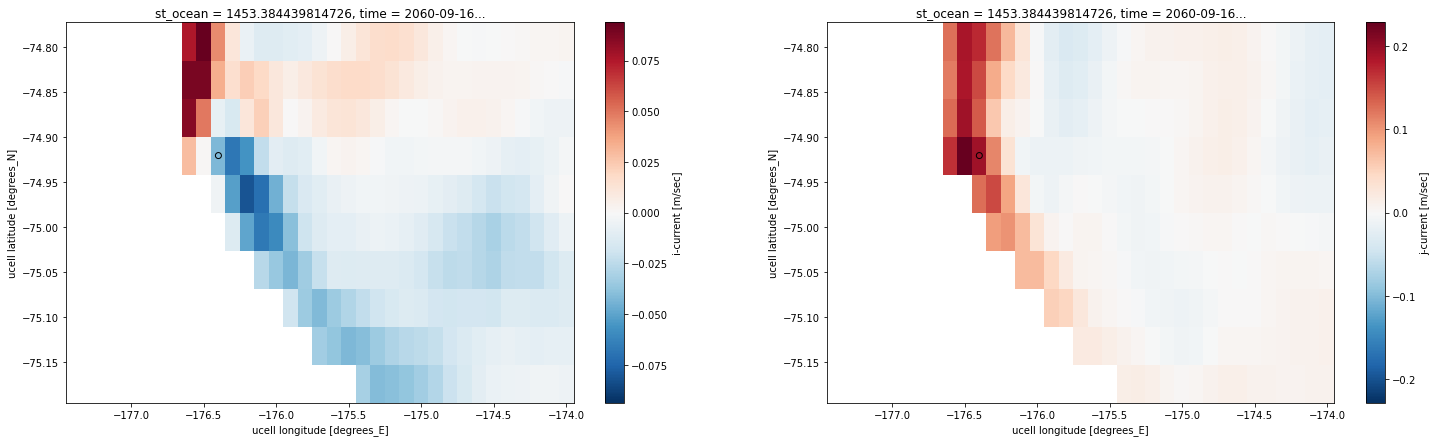

In [15]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(25,7))

lims = (2400,3400,2000,-1) # North Atlantic

lims = (3200,3300,2600,2650) # Sverny Island

lims = (2450,2550,2100,2150) # NA over-flow

lims = (1920,1940,2100,2120) # Hudson Bay

lims = (1656,1680,2410,2435) # Hudson Bay 2

lims = (1025,1060,140,150)

fname = '/scratch/e14/rmh561/access-om2/archive/01deg_jra55_ryf_k_smag_iso7p9/output638/ocean/ocean.nc'

data = xr.open_dataset(fname)
#u = np.abs(data.u.isel(time=-1).isel(yu_ocean=slice(lims[2],lims[3])).isel(xu_ocean=slice(lims[0],lims[1])))
u = data.u.isel(time=-1).isel(yu_ocean=slice(lims[2],lims[3])).isel(xu_ocean=slice(lims[0],lims[1]))
#umax = u.max('st_ocean')
#umax.plot(ax = axes[0])
u.isel(st_ocean=50).plot(ax=axes[0],cmap='RdBu_r')

data = xr.open_dataset(fname)
#v = np.abs(data.v.isel(time=-1).isel(yu_ocean=slice(lims[2],lims[3])).isel(xu_ocean=slice(lims[0],lims[1])))
v = data.v.isel(time=-1).isel(yu_ocean=slice(lims[2],lims[3])).isel(xu_ocean=slice(lims[0],lims[1]))
#vmax = v.max('st_ocean')
#vmax.plot(ax = axes[1])
#vmax.plot.contour(ax=axes[1],levels=[4.,5.,6.],color='r')
v.isel(st_ocean=50).plot(ax=axes[1],cmap='RdBu_r')

# Plot Rayleigh drag values over the top:
ftde = ft_data['01deg']
if len(ftde['damp_time']) > 0:
    axes[0].scatter(data.xu_ocean.isel(xu_ocean=ftde['damp_table_ii']),data.yu_ocean.isel(yu_ocean=ftde['damp_table_jj']), facecolors='none', edgecolors='k')
    axes[1].scatter(data.xu_ocean.isel(xu_ocean=ftde['damp_table_ii']),data.yu_ocean.isel(yu_ocean=ftde['damp_table_jj']), facecolors='none', edgecolors='k')

In [36]:
print('Data from field_table (NB: damp_table_ii and damp_table_jj have had 1 subtracted)')
for ekey in ft_data.keys():
    print(ekey)
    ftde = ft_data[ekey]
    if len(ftde['damp_time']) > 0:
        for k in ['damp_table_ii', 'damp_table_jj', 'ktable_1', 'ktable_2', 'damp_time']:
            print(k, ' = ', str(ftde[k]))

Data from field_table (NB: damp_table_ii and damp_table_jj have had 1 subtracted)
1deg
damp_table_ii  =  [35, 43, 61, 61, 61, 61]
damp_table_jj  =  [111, 110, 105, 106, 107, 108]
ktable_1  =  [1, 1, 1, 1, 1, 1]
ktable_2  =  [50, 50, 50, 50, 50, 50]
damp_time  =  [5400, 5400, 5400, 5400, 5400, 5400]
025deg
01deg
damp_table_ii  =  [3224, 3224, 3224, 3225, 3223, 3223, 3223, 3222, 3222, 3222, 3221, 3221, 3221, 3220, 3220, 3220, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342]
damp_table_jj  =  [2612, 2613, 2614, 2614, 2613, 2614, 2615, 2614, 2615, 2616, 2615, 2616, 2617, 2616, 2617, 2618, 2108, 2108, 2108, 2108, 2108, 2108, 2108, 2107, 2107, 2107, 2107, 2107, 2107, 2107, 2379, 2379, 2379, 2379, 2379, 2379, 2379, 2379, 2

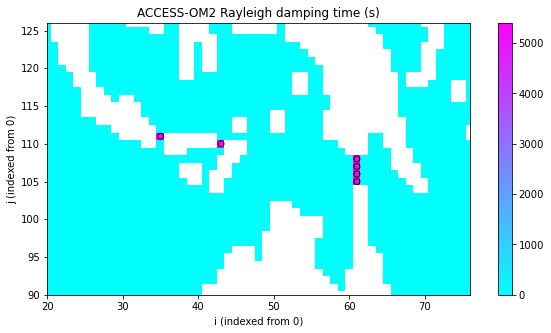

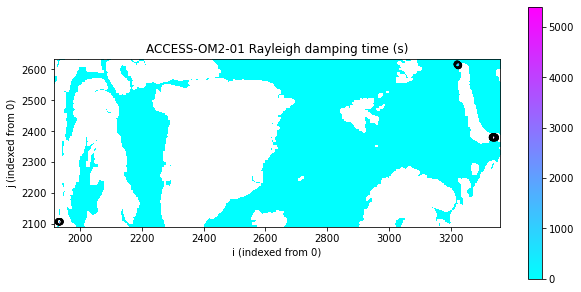

In [37]:
# damping rate plots
margin = 15  # grid cells
for ekey in ft_data.keys():
    ftde = ft_data[ekey]
    if len(ftde['damp_time']) > 0:
        imin = min(ftde['damp_table_ii']) - margin
        imax = max(ftde['damp_table_ii']) + margin
        jmin = min(ftde['damp_table_jj']) - margin
        jmax = max(ftde['damp_table_jj']) + margin
        plt.figure(figsize=(10,5),facecolor='w')
        plt.imshow(ftde['damp_time_map'], origin='lower', cmap=plt.get_cmap('cool'))
        plt.colorbar()
        plt.scatter(ftde['damp_table_ii'],ftde['damp_table_jj'], facecolors='none', edgecolors='k')
        plt.xlim(imin,imax)
        plt.ylim(jmin,jmax)
        plt.title(ftde['desc']+' Rayleigh damping time (s)')
        plt.xlabel('i (indexed from 0)')
        plt.ylabel('j (indexed from 0)')
#    savefigure('Rayleigh_damp_time_'+ekey)

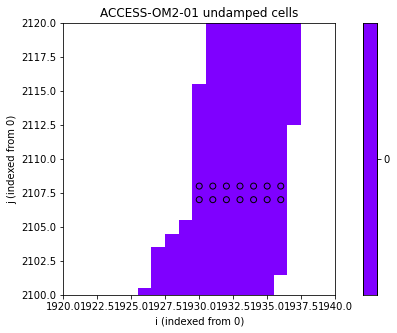

In [46]:
# missing cell plots
margin = 15  # grid cells
maxundamped = int(max([ft_data[ekey]['undamped'].max() for ekey in ['1deg']]).values.tolist())

ekey = '01deg'
#for ekey in ft_data.keys():
ftde = ft_data[ekey]
if len(ftde['damp_time']) > 0:
    imin = min(ftde['damp_table_ii']) - margin
    imax = max(ftde['damp_table_ii']) + margin
    jmin = min(ftde['damp_table_jj']) - margin
    jmax = max(ftde['damp_table_jj']) + margin
    imin,imax,jmin,jmax = 1920,1940,2100,2120 # Hudson Bay
    plt.figure(figsize=(10,5))
    plt.imshow(ftde['undamped'], origin='lower', cmap=plt.get_cmap('rainbow',maxundamped+1))
    plt.colorbar(ticks=range(maxundamped+1))
    plt.clim(-0.5, maxundamped+0.5)
    plt.scatter(ftde['damp_table_ii'],ftde['damp_table_jj'], facecolors='none', edgecolors='k')
    plt.xlim(imin,imax)
    plt.ylim(jmin,jmax)
    plt.title(ftde['desc']+' undamped cells')
    plt.xlabel('i (indexed from 0)')
    plt.ylabel('j (indexed from 0)')
#        savefigure('Rayleigh_undamped_cells_'+ekey)